In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from mini_torch import Tensor, nn, optim, F, schedulers

## Load CIFAR-10 Dataset

In [6]:
from torchvision.datasets import CIFAR10
import numpy as np

try:
    # This downloads it automatically if missing
    train_data = CIFAR10(root='./data', train=True, download=True)
    test_data = CIFAR10(root='./data', train=False, download=True)

    # Convert to standard numpy format (N, C, H, W) for your library
    # CIFAR10 defaults to (N, H, W, C), so we transpose
    X_train = train_data.data.transpose((0, 3, 1, 2)).astype(np.float32) / 255.0
    y_train = np.array(train_data.targets)
    
    X_test = test_data.data.transpose((0, 3, 1, 2)).astype(np.float32) / 255.0
    y_test = np.array(test_data.targets)
    
    # Subset for testing
    X_train, y_train = X_train[:2000], y_train[:2000]
    X_test, y_test = X_test[:500], y_test[:500]
    
    class_names = train_data.classes
    print("CIFAR-10 loaded via Torchvision!")
    
except:
    print("CIFAR-10 not found. Creating synthetic dataset for demonstration...")
    # Create synthetic data similar to CIFAR-10
    np.random.seed(42)
    X_train = np.random.rand(2000, 3, 32, 32).astype(np.float32)
    y_train = np.random.randint(0, 10, 2000)
    X_test = np.random.rand(500, 3, 32, 32).astype(np.float32)
    y_test = np.random.randint(0, 10, 500)
    class_names = [f'class_{i}' for i in range(10)]

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Number of classes: {len(class_names)}")

100.0%
/home/milik/Documents/scia/s9/prdi/project/mini-torch/.venv/lib/python3.13/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


CIFAR-10 loaded via Torchvision!
Training set: (2000, 3, 32, 32)
Test set: (500, 3, 32, 32)
Number of classes: 10


## Visualize Sample Images

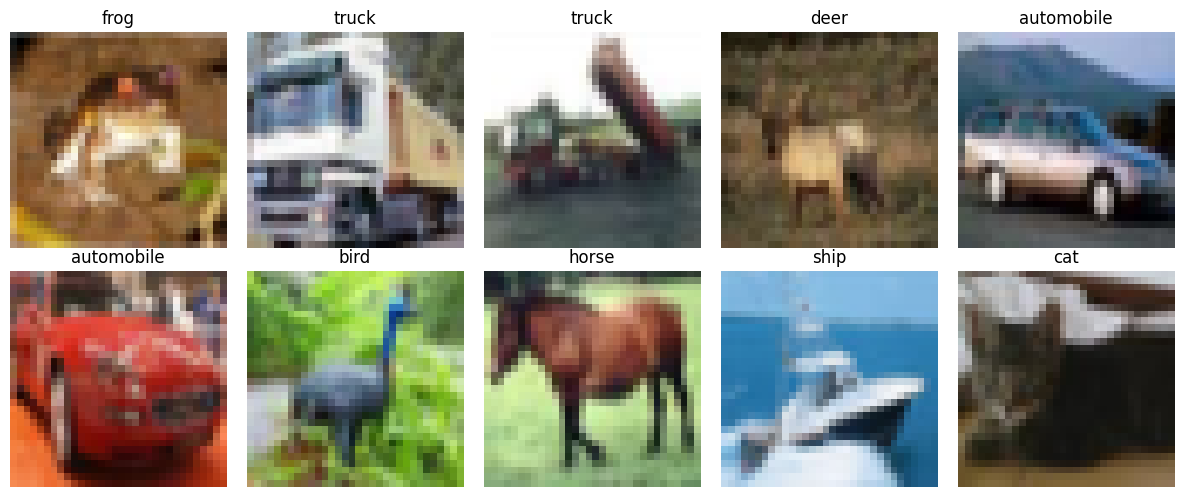

In [7]:
# Visualize some examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    # Transpose from CHW to HWC for display
    img = X_train[i].transpose(1, 2, 0)
    ax.imshow(img)
    ax.set_title(f'{class_names[y_train[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Define ResNet Building Blocks

In [4]:
class ResidualBlock(nn.Module):
    """Basic residual block for ResNet"""
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        
        # First convolution
        self.conv1 = nn.Conv2D(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2D(out_channels)
        
        # Second convolution
        self.conv2 = nn.Conv2D(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2D(out_channels)
        
        # Downsample for skip connection if dimensions don't match
        self.downsample = downsample
        
        # Collect parameters
        self._parameters = (self.conv1.parameters() + self.bn1.parameters() + 
                           self.conv2.parameters() + self.bn2.parameters())
        if downsample is not None:
            self._parameters.extend(downsample.parameters())
    
    def forward(self, x):
        identity = x
        
        # First conv block
        out = self.conv1(x)
        out = self.bn1(out)
        out = out.relu()
        
        # Second conv block
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Skip connection
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # Add skip connection
        out = out + identity
        out = out.relu()
        
        return out

## Define ResNet-18 Architecture

In [5]:
class ResNet18(nn.Module):
    """ResNet-18 for CIFAR-10 (32x32 images)"""
    
    def __init__(self, num_classes=10):
        super().__init__()
        
        # Initial convolution (modified for CIFAR-10's 32x32 images)
        self.conv1 = nn.Conv2D(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2D(64)
        
        # ResNet layers
        self.layer1 = self._make_layer(64, 64, stride=1)  # 2 blocks
        self.layer2 = self._make_layer(64, 128, stride=2)  # 2 blocks
        self.layer3 = self._make_layer(128, 256, stride=2)  # 2 blocks
        self.layer4 = self._make_layer(256, 512, stride=2)  # 2 blocks
        
        # Pooling and classifier
        self.avgpool = nn.AvgPool2D(kernel_size=4)  # Global average pooling
        self.fc = nn.Linear(512, num_classes)
        
        # Collect all parameters
        self._parameters = (self.conv1.parameters() + self.bn1.parameters())
        for layer in [self.layer1, self.layer2, self.layer3, self.layer4]:
            for block in layer:
                self._parameters.extend(block.parameters())
        self._parameters.extend(self.fc.parameters())
    
    def _make_layer(self, in_channels, out_channels, stride):
        """Create a ResNet layer with 2 residual blocks"""
        downsample = None
        
        # Downsample if stride != 1 or channels change
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2D(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm2D(out_channels)
            )
        
        layers = []
        # First block (may downsample)
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
        # Second block
        layers.append(ResidualBlock(out_channels, out_channels))
        
        return layers
    
    def forward(self, x):
        # Initial convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = x.relu()
        
        # ResNet layers
        for block in self.layer1:
            x = block(x)
        for block in self.layer2:
            x = block(x)
        for block in self.layer3:
            x = block(x)
        for block in self.layer4:
            x = block(x)
        
        # Global average pooling
        x = self.avgpool(x)
        
        # Flatten
        batch_size = x.shape[0]
        x = x.reshape(batch_size, -1)
        
        # Classifier
        x = self.fc(x)
        
        return x

# Create model
print("Creating ResNet-18 model...")
model = ResNet18(num_classes=10)
print(f"Model created with {len(model.parameters())} parameter tensors")

Creating ResNet-18 model...
Model created with 62 parameter tensors


## Training and Evaluation Functions

In [6]:
def train_epoch(model, X_train, y_train, optimizer, batch_size=16):
    """Train for one epoch"""
    model.train()
    n_samples = X_train.shape[0]
    indices = np.random.permutation(n_samples)
    
    epoch_loss = 0.0
    n_batches = 0
    
    for i in range(0, n_samples, batch_size):
        # Get batch
        batch_indices = indices[i:i+batch_size]
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]
        
        # Convert to Tensors
        X_tensor = Tensor(X_batch)
        y_tensor = Tensor(y_batch.astype(np.float32), requires_grad=False)
        
        # Forward pass
        logits = model(X_tensor)
        
        # Compute loss
        loss = F.cross_entropy(logits, y_tensor)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
        
        if (n_batches) % 20 == 0:
            print(f"  Batch {n_batches}/{n_samples//batch_size}, Loss: {loss.item():.4f}")
    
    return epoch_loss / n_batches


def evaluate(model, X_test, y_test, batch_size=16):
    """Evaluate model accuracy"""
    model.eval()
    n_samples = X_test.shape[0]
    correct = 0
    total = 0
    total_loss = 0.0
    n_batches = 0
    
    for i in range(0, n_samples, batch_size):
        X_batch = X_test[i:i+batch_size]
        y_batch = y_test[i:i+batch_size]
        
        # Convert to Tensor
        X_tensor = Tensor(X_batch)
        y_tensor = Tensor(y_batch.astype(np.float32), requires_grad=False)
        
        # Forward pass
        logits = model(X_tensor)
        
        # Compute loss
        loss = F.cross_entropy(logits, y_tensor)
        total_loss += loss.item()
        n_batches += 1
        
        # Get predictions
        predictions = np.argmax(logits.data, axis=1)
        
        correct += (predictions == y_batch).sum()
        total += len(y_batch)
    
    return correct / total, total_loss / n_batches

## Train ResNet-18

In [ ]:
# Training configuration
n_epochs = 15
batch_size = 32
learning_rate = 0.01

# Create optimizer and scheduler
optimizer = optim.SGD(model.parameters(), learning_rate=learning_rate)
# Alternative: optimizer = optim.Adam(model.parameters(), learning_rate=0.001)

scheduler = schedulers.StepLR(optimizer, initial_lr=learning_rate, step_size=5, gamma=0.1)

# Training loop
train_losses = []
test_losses = []
test_accuracies = []

print("\n" + "="*70)
print("Starting ResNet-18 Training")
print("="*70)

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    print("-"*70)
    
    # Train
    train_loss = train_epoch(model, X_train, y_train, optimizer, batch_size)
    train_losses.append(train_loss)
    
    # Evaluate
    test_acc, test_loss = evaluate(model, X_test, y_test, batch_size)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Update learning rate
    scheduler.step()
    
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Learning Rate: {optimizer.learning_rate:.6f}")

print("\n" + "="*70)
print("Training completed!")
print("="*70)


Starting ResNet-18 Training

Epoch 1/15
----------------------------------------------------------------------
  Batch 20/62, Loss: 2.3348
  Batch 40/62, Loss: 2.3611


## Visualize Training Results

In [ ]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(train_losses, marker='o', label='Train Loss', linewidth=2)
ax1.plot(test_losses, marker='s', label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Test Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curve
ax2.plot(test_accuracies, marker='o', color='green', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Test Accuracy', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest Test Accuracy: {max(test_accuracies):.4f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")

## Visualize Predictions

In [ ]:
# Visualize predictions on test set
n_samples_viz = 20
X_viz = X_test[:n_samples_viz]
y_viz = y_test[:n_samples_viz]

X_tensor = Tensor(X_viz)
logits = model(X_tensor)
predictions = np.argmax(logits.data, axis=1)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for i, ax in enumerate(axes.flat):
    img = X_viz[i].transpose(1, 2, 0)  # CHW to HWC
    ax.imshow(img)
    color = 'green' if predictions[i] == y_viz[i] else 'red'
    true_label = class_names[y_viz[i]]
    pred_label = class_names[predictions[i]]
    ax.set_title(f'True: {true_label}\nPred: {pred_label}', color=color, fontsize=10)
    ax.axis('off')

plt.suptitle('ResNet-18 Predictions (Green=Correct, Red=Wrong)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate accuracy on visualized samples
accuracy = (predictions == y_viz).sum() / len(y_viz)
print(f"\nAccuracy on visualized samples: {accuracy:.2%}")

## Confusion Matrix

In [ ]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get all predictions
all_predictions = []
batch_size = 32
for i in range(0, len(X_test), batch_size):
    X_batch = X_test[i:i+batch_size]
    X_tensor = Tensor(X_batch)
    logits = model(X_tensor)
    preds = np.argmax(logits.data, axis=1)
    all_predictions.extend(preds)

# Compute confusion matrix
cm = confusion_matrix(y_test, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()